In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
# Define transformations (normalize to match pre-trained settings)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        return torch.relu(out)



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
def fgsm_attack(model, images, labels, epsilon=0.1):
    images = images.clone().detach().to("cuda").requires_grad_(True)
    labels = labels.to("cuda")

    output = model(images)
    loss = nn.CrossEntropyLoss()(output, labels)

    model.zero_grad()
    loss.backward()

    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)  # Keep pixel values in valid range
    return adv_images.detach()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 30
epsilon = 0.1  # FGSM perturbation strength

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = fgsm_attack(model, images, labels, epsilon=epsilon)

        # Forward pass on clean and adversarial images
        optimizer.zero_grad()
        clean_outputs = model(images)
        adv_outputs = model(adv_images)

        loss_clean = criterion(clean_outputs, labels)
        loss_adv = criterion(adv_outputs, labels)
        alpha = max(0.5, 1-epoch/num_epochs)
        loss = alpha * loss_clean + (1-alpha)*loss_adv

        # Backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Save the adversarially trained model
torch.save(model.state_dict(), "/kaggle/working/cifar10_adv_train.pth")

In [7]:
import random

target_class = torch.tensor([9], dtype=torch.long, device="cuda")
model = model.to("cuda")
model.eval()
c = 0
l = 0
for i in range(100):
    j = random.randint(1, len(trainset))
    input_image = trainset[j][0].unsqueeze(0).to("cuda")
    input_image = input_image.detach().clone()
    input_image.requires_grad_(True)
    output = model(input_image)
    loss = -torch.nn.functional.cross_entropy(output, target_class)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        input_image += 0.1 * input_image.grad.sign()
        input_image.clamp_(0, 1)
    input_image.grad.zero_()
    a = model(input_image)
    pred = torch.argmax(torch.nn.functional.softmax(a, dim=1)).item()
    if pred == trainset[j][1]:
        c += 1
    l += loss.item()
print(c / 100)
print("average loss", l / 100)

0.74
average loss -14.89153348822681


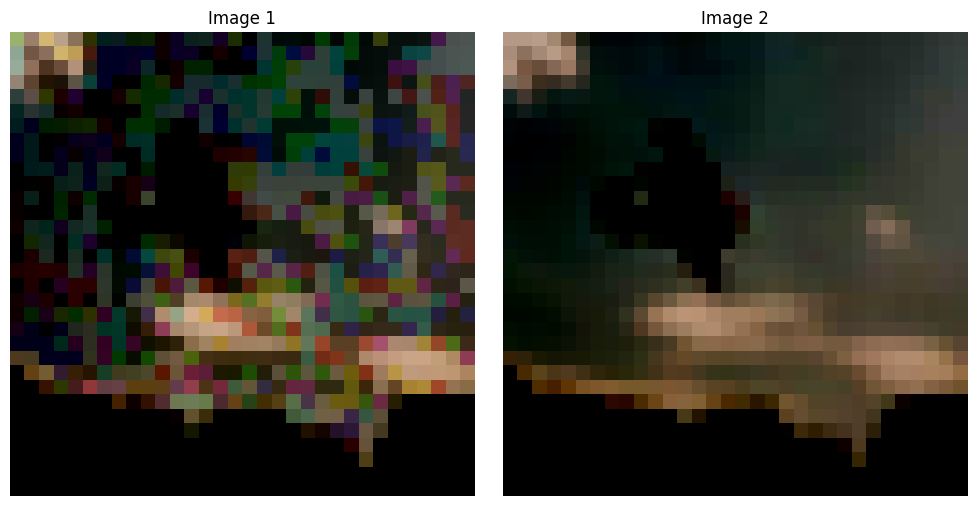

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image.detach().cpu()[0].permute(1, 2, 0).numpy())
axes[0].axis('off')
axes[0].set_title("Image 1")

axes[1].imshow(np.transpose(trainset[j][0], (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title("Image 2")

plt.tight_layout()
plt.show()

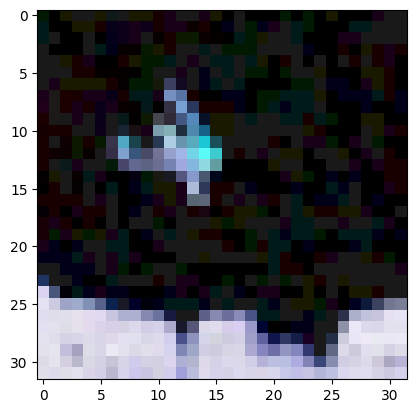

In [11]:
plt.imshow(input_image.detach().cpu()[0].permute(1, 2, 0) - np.transpose(trainset[j][0], (1, 2, 0)))
plt.show()